# Linear mixed-effects models

<br>
We talked about linear mixed-effects models in the lecture today. Let's see how we can use the linear mixed-effects tools in r. For this we will need to install the [lme4](https://cran.r-project.org/web/packages/lme4/lme4.pdf) library in r. 

In [3]:
# Clear the workspace again
rm(list=ls())

# Install LME4
#install.packages("lme4") # Uncomment if not installed.
library(lme4)
library(ggplot2)

Loading required package: Matrix



This library includes a sleep study experiment that we can use to practice fitting a mixed-effect model.

In [4]:
#help(sleepstudy) # Uncomment to see documentation
names(sleepstudy)
head(sleepstudy)

[1] "Reaction" "Days"     "Subject"

,Reaction,Days,Subject
,<dbl>,<dbl>,<fct>
1,249.5600,0,308
2,258.7047,1,308
3,250.8006,2,308
4,321.4398,3,308
5,356.8519,4,308
6,414.6901,5,308


Summary: "The average reaction time per day for subjects in a sleep deprivation study. On day 0 the subjects had their normal amount of sleep. Starting that night they were restricted to 3 hours of sleep per night. The observations represent the average reaction time on a series of tests given each day to each subject."

Thus we have a data frame with 180 observations on the following 3 variables.

* **Reaction:** Average reaction time (ms)

* **Days:** Number of days of sleep deprivation

* **Subject:**  Subject number on which the observation was made.

The main question we have here is whether days of consecutive sleep deprivation impact reaction times.  This boils down to a repeated measures problem: the same subjects are tested across multiple days, so random effects associated with each individual will also carry over across days, violating the assumption that each observation is independent and identically distributed (i.e., _iid_).



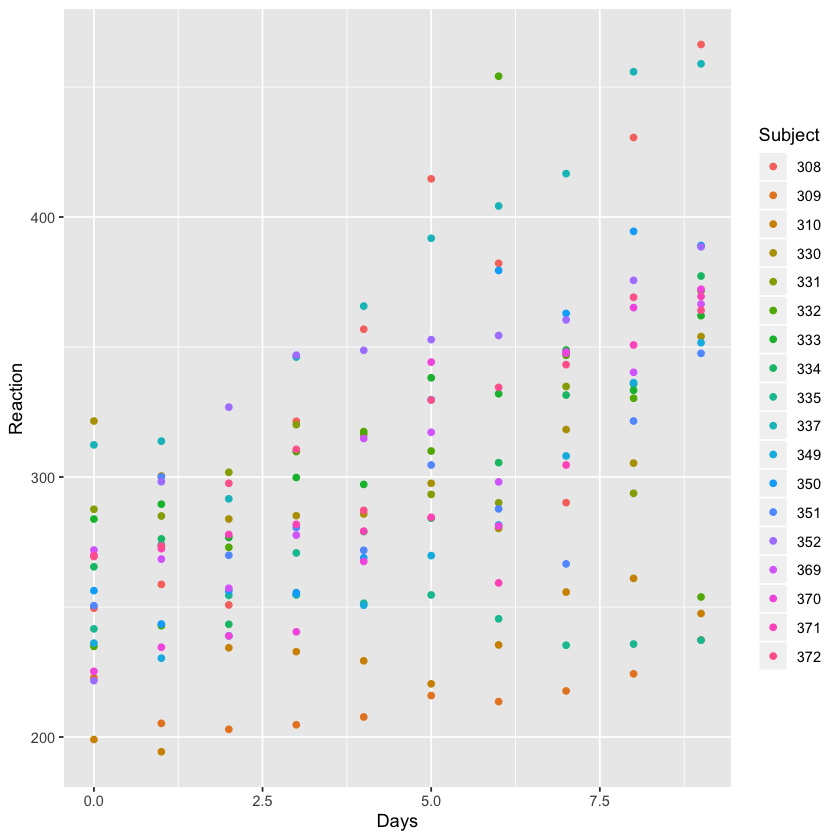

In [54]:
# Let's take a look at the fixed effects
# attach(sleepstudy)
# plot(Days, Reaction) 
# we can plot the data by days and then grouped by subjects
ggplot(sleepstudy, aes(Days, Reaction, color = Subject)) + 
geom_point()
# What assumption in a regression model are we violating? 

In [9]:
# First let's try the simple linear fit anyways and see what we get
fe.fit = lm(Reaction~Days, data=sleepstudy)
summary(fe.fit)


Call:
lm(formula = Reaction ~ Days, data = sleepstudy)

Residuals:
     Min       1Q   Median       3Q      Max 
-110.848  -27.483    1.546   26.142  139.953 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  251.405      6.610  38.033  < 2e-16 ***
Days          10.467      1.238   8.454 9.89e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 47.71 on 178 degrees of freedom
Multiple R-squared:  0.2865,	Adjusted R-squared:  0.2825 
F-statistic: 71.46 on 1 and 178 DF,  p-value: 9.894e-15


Notice that we are still getting a significant effect of days of sleep deprivation on reaction time, even if we ignore the fact that the same subjects are sampled across all days.
<br><br>
However, in order to account for those subject effects, let's treat them as a random effect. In this case we will assume that the effect of sleep deprivation on reaction times varies by subject. 
<br><br>
In _lmer_, random-effects terms are distinguished by vertical bars (|) separating expressions for design matrices from grouping factors. 

In [31]:
# Now let's account for the random impact of subject variance on the model
me.fit1 = lmer(Reaction ~ Days +  (Days | Subject), data=sleepstudy) 
# the same as me.fit1 = lmer(Reaction ~ Days +  (1+Days | Subject), data=sleepstudy) 
me.fit2 = lmer(Reaction ~ Days + (1 | Subject), data=sleepstudy) #post references on mixed effects
print('ME.FIT1')
summary(me.fit1)
print('ME.FIT2')
summary(me.fit2)

[1] "ME.FIT1"


Linear mixed model fit by REML ['lmerMod']
Formula: Reaction ~ Days + (Days | Subject)
   Data: sleepstudy

REML criterion at convergence: 1743.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9536 -0.4634  0.0231  0.4633  5.1793 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 Subject  (Intercept) 611.90   24.737       
          Days         35.08    5.923   0.07
 Residual             654.94   25.592       
Number of obs: 180, groups:  Subject, 18

Fixed effects:
            Estimate Std. Error t value
(Intercept)  251.405      6.824  36.843
Days          10.467      1.546   6.771

Correlation of Fixed Effects:
     (Intr)
Days -0.138

[1] "ME.FIT2"


Linear mixed model fit by REML ['lmerMod']
Formula: Reaction ~ Days + (1 | Subject)
   Data: sleepstudy

REML criterion at convergence: 1786.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2257 -0.5529  0.0109  0.5188  4.2506 

Random effects:
 Groups   Name        Variance Std.Dev.
 Subject  (Intercept) 1378.2   37.12   
 Residual              960.5   30.99   
Number of obs: 180, groups:  Subject, 18

Fixed effects:
            Estimate Std. Error t value
(Intercept) 251.4051     9.7467   25.79
Days         10.4673     0.8042   13.02

Correlation of Fixed Effects:
     (Intr)
Days -0.371

The random effects: `(Days | Subject)`  allows individual subjects to vary randomly in terms of their intercept (starting reaction time) and for each person, the effect of the number of days of sleep lost on reaction time is estimated (reaction time change over days, also called a “random slope”).

If we look at the t-value for Days on Reaction in the Fixed effects, it has dropped to 6.77 (from 8.45 in the simple linear model). Thus we are getting a more conservative model fit on the fixed effects.

Notice that the report on the random effects doesn't provide an inferential statistic (i.e., a t-value). That is because interpreting the magnitude of the random effect is meaningless because we defined those effects as tangential to the fixed effect that we are looking for. We are not looking for how variability in individuals changes the effect of sleep loss over time or at individual differences in the baseline reaction times. Instead, we are trying to estimate the fixed effects, taking into account this random variation.  

Therefore, to interpret the value of including the random effects term in your model, you will want to do a model comparison instead. Specifically, you might want to test whether the mixed-effect model provides a better fit to the data than the simple linear regression model.  

Remember the bias-variance tradeoff, and how a more complex model will generally provide a better fit? These two models have different model complexities, so you'll have to use an evaluation criterion that takes complexity into account (e.g., AIC). For now you can think of the AIC as quanitifying the amount of information lost or the variance unexplained (so a lower score would be better). 

In [32]:
# We will compare the two models using the Akaike information criterion (AIC)
ic = AIC(fe.fit, me.fit1, me.fit2)
ic
diff(ic$AIC)

,df,AIC
,<dbl>,<dbl>
fe.fit,3,1906.293
me.fit1,6,1755.628
me.fit2,4,1794.465


[1] -150.66478   38.83681

This difference in AIC is quite big, which means that the more complex model (the mixed-effects model) accounts for substantially more variance in reaction time than the simple linear model, even after accounting for its increased complexity. 